In [134]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [135]:
# Physical constants
h = 6.626070040e-34  # Planck's constant [J*s]
c = 299792458  # Speed of light [m/s]
k = 1.38064852e-23  # Boltzmann constant
sigma = 5.670367e-8  # Stefan-Boltzmann constant [W / (m^2 K^4)]
N_A = 6.022140758e23  # Avogadro's constant [molecules/mol]

R = 287.058  # Dry air gas constant [J/kg/K]
g = 9.80665  # Standard gravity [m/s^2]

# CO_2 constants
nu_0 = 601.557  # Line frequency [cm^-1]
S_0 = 2.4e-21  # Line strength [cm^2 / molecule / cm]
gamma_0 = 0.0713  # Line width [cm^-1]
n = 0.76  # Line-width exponent
nu_l = 847.8  # cm^-1 (Note: h*nu_l is the energy of the lower energy state)
m_CO2 = 44.02e-3  # Molar mass [kg/mol]

# Reference conditions
p_0 = 1e5  # [Pa]
T_0 = 296  # [K]
D = 1.5  # Two-stream diffusivity factor in the longwave

# 1976 US Standard Atmosphere constants
T_g = 288.15  # Ground temperature [K]

In [136]:
def gamma(p, T):
    return gamma_0 * (p/p_0) * np.power(T_0/T, n)

In [137]:
def Q(T):
    return T

In [138]:
def S(T):
    return S_0 * (Q(T_0)/Q(T)) * np.power(T/T_0, n) * np.exp(-(h*c*nu_l/k) * (1/T - 1/T_0))

In [139]:
def kappa(nu, p, T):
    return (S(T)/gamma(p,T)) / (np.pi * (1 + ( (nu_0 - nu)/gamma(p,T) )**2))

In [140]:
# 1976 US Standard Atmosphere temperature profile from surface to 20 km.
def T(z):
    Gamma = -6.5  # lapse rate from surface to 11 km [K/km]
    if z < 11000:
        return (288.15) + Gamma*(z/1000)
    elif 11000 <= z <= 20000:
        return (288.15) + Gamma*11
    else:
        raise ValueError('Standard atmosphere temperature profile not implemented above 20 km.')

In [141]:
def p(z):
    return p_0 * np.exp(-g*z/(R*T_0))

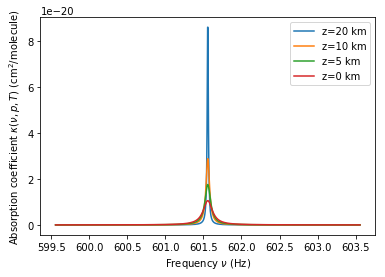

In [142]:
# Problem 2(a)
nu_values = np.linspace(nu_0-2, nu_0+2, 1000)

for z in [20000, 10000, 5000, 0]:
    kappa_values = list(map(lambda nu: kappa(nu=nu, p=p(z), T=T(z)), nu_values))
    plt.plot(nu_values, kappa_values, label=r'z={:d} km'.format(int(z/1000)))

plt.xlabel(r'Frequency $\nu$ (Hz)')
plt.ylabel(r'Absorption coefficient $\kappa(\nu, p, T)$ (cm$^2$/molecule)')
plt.legend()
plt.show()

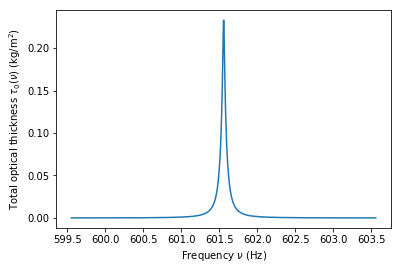

Total optical thickness at line center: tau_0(601.557 cm^-1) = 0.232687 kg/m^2
Total optical thickness 1 cm^-1 away from line center: tau_0(600.557 cm^-1) = 0.000329 kg/m^2


In [143]:
# Problem 2(b)
r_CO2 = 400e-6  # CO2 volumetric mixing rate (400 ppmv)

nu_values = np.linspace(nu_0-2, nu_0+2, 1000)

z_values = np.linspace(0, 20000, 1000)
p_values = p(z_values)
T_values = list(map(lambda z: T(z), z_values))

tau_0_values = np.zeros(1000)
for i in np.arange(nu_values.size):
    nu_i = nu_values[i]
    
    integrand_values = np.zeros(1000)
    for j in np.arange(p_values.size):
        p_j = p_values[j]
        T_j = T_values[j]
        integrand_values[j] = -kappa(nu=nu_i, p=p_j, T=T_j) * r_CO2 / g
    tau_0_values[i] = np.trapz(integrand_values, p_values)

# Converting to [kg/m^2]
tau_0_values = tau_0_values * (1/10000) * N_A * m_CO2
    
plt.plot(nu_values, tau_0_values)
plt.xlabel(r'Frequency $\nu$ (Hz)')
plt.ylabel(r'Total optical thickness $\tau_0(\nu)$ (kg/m$^2$)')
plt.show()

print('Total optical thickness at line center: tau_0(601.557 cm^-1) = {:f} kg/m^2'.format(tau_0_values[500]))
print('Total optical thickness 1 cm^-1 away from line center: tau_0(600.557 cm^-1) = {:f} kg/m^2'.format(tau_0_values[250]))

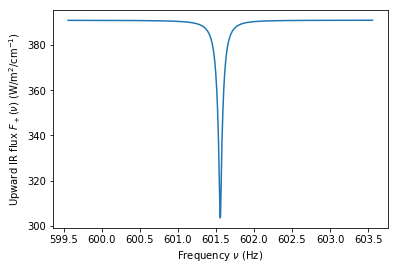

Effective radiating temperature at line center: T_rad(601.557 cm^-1) = 270.512146 K
Effective radiating temperature 1 cm^-1 away from line center: T_rad(600.557 cm^-1) = 288.115759 K


In [146]:
# Problem 2(c)
z_values = np.linspace(0, 20000, 1000)
p_values = p(z_values)
T_values = list(map(lambda z: T(z), z_values))

upward_IR_flux_values = np.zeros(1000)
for i in np.arange(nu_values.size):
    tau_values = tau_0_values[i] * np.power(p_values/p_0, n)
    integrand_values = sigma * np.power(T_values, 4) * np.exp(-D * tau_values)
    
    # Calculate upward fluxes due to emission from the surface and from the atmosphere
    surface_term = sigma * T_g**4 * np.exp(-D * tau_values[i])
    atmosphere_term = np.trapz(integrand_values, tau_values)
    
    upward_IR_flux_values[i] = surface_term + atmosphere_term
    
plt.plot(nu_values, upward_IR_flux_values)
plt.xlabel(r'Frequency $\nu$ (Hz)')
plt.ylabel(r'Upward IR flux $F_+(\nu)$ (W/m$^2$/cm$^{-1}$)')
plt.show()

print('Effective radiating temperature at line center: T_rad(601.557 cm^-1) = {:f} K'.format(np.power(upward_IR_flux_values[500]/sigma, 1/4)))
print('Effective radiating temperature 1 cm^-1 away from line center: T_rad(600.557 cm^-1) = {:f} K'.format(np.power(upward_IR_flux_values[250]/sigma, 1/4)))

upward_IR_flux_400ppm_values = upward_IR_flux_values

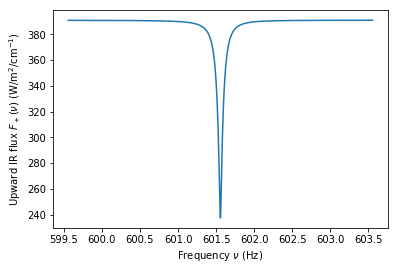

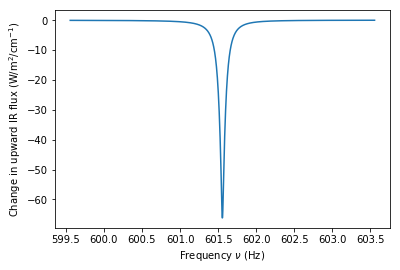

This one line changes the total OLR by -8.652219 W/m^2 after a doubling of CO2 from 400 ppm to 800 ppm.


In [149]:
# Problem 2(d): Repeating parts (c) and (d) but with a CO2 doubling.
r_CO2 = 800e-6  # CO2 volumetric mixing rate (800 ppmv)

nu_values = np.linspace(nu_0-2, nu_0+2, 1000)

z_values = np.linspace(0, 20000, 1000)
p_values = p(z_values)
T_values = list(map(lambda z: T(z), z_values))

tau_0_values = np.zeros(1000)
for i in np.arange(nu_values.size):
    nu_i = nu_values[i]
    
    integrand_values = np.zeros(1000)
    for j in np.arange(p_values.size):
        p_j = p_values[j]
        T_j = T_values[j]
        integrand_values[j] = -kappa(nu=nu_i, p=p_j, T=T_j) * r_CO2 / g
    tau_0_values[i] = np.trapz(integrand_values, p_values)

# Converting to [kg/m^2]
tau_0_values = tau_0_values * (1/10000) * N_A * m_CO2

upward_IR_flux_values = np.zeros(1000)
for i in np.arange(nu_values.size):
    tau_values = tau_0_values[i] * np.power(p_values/p_0, n)
    integrand_values = sigma * np.power(T_values, 4) * np.exp(-D * tau_values)
    
    # Calculate upward fluxes due to emission from the surface and from the atmosphere
    surface_term = sigma * T_g**4 * np.exp(-D * tau_values[i])
    atmosphere_term = np.trapz(integrand_values, tau_values)
    
    upward_IR_flux_values[i] = surface_term + atmosphere_term
    
plt.plot(nu_values, upward_IR_flux_values)
plt.xlabel(r'Frequency $\nu$ (Hz)')
plt.ylabel(r'Upward IR flux $F_+(\nu)$ (W/m$^2$/cm$^{-1}$)')
plt.show()

# Calculate and plot the difference in the two upward IR flux curves.
upward_IR_flux_800ppm_values = upward_IR_flux_values
delta_upward_IR_flux_values = upward_IR_flux_800ppm_values - upward_IR_flux_400ppm_values

plt.plot(nu_values, delta_upward_IR_flux_values)
plt.xlabel(r'Frequency $\nu$ (Hz)')
plt.ylabel(r'Change in upward IR flux (W/m$^2$/cm$^{-1}$)')
plt.show()

print('This one line changes the total OLR by {:f} W/m^2 after a doubling of CO2 from 400 ppm to 800 ppm.'.format(np.trapz(delta_upward_IR_flux_values, nu_values)))